In [1]:
import pandas as pd
import datetime
import numpy as np

# local file paths
input_file_path = f'../../../siads591 data/filtered_raw/gabbard_min.pkl.gz'
out_path = f'../../../siads591 data/processed_data/gabbard/'

# freq             frequency of datapoints after reindexing
# start_date       start date for data to start processing - remember to leave enough gap for interpolation
# interpolate_lim  limits of interpolation based on the frequency
#                  (1D frequency, 30 limit = 30 days 1 way, effectively a max of 60 days between points)
# out_file_name    output file name

freq, start_date, interpolate_lim, out_file_name = '1D', '1979-10-01', 45, 'gabbard_1D_scaled_1980.pkl'
# freq, start_date, interpolate_lim, out_file_name = '12H', '1979-10-01', 90, 'gabbard_scaled_1980.pkl'
# freq, start_date, interpolate_lim, out_file_name = '5D', None, 12, 'gabbard_5D_scaled.pkl'

In [2]:
raw_df = pd.read_pickle(f'{input_file_path}', compression="gzip")

In [3]:
if start_date != None:
    raw_df = raw_df[raw_df.index > start_date]

In [4]:
display(raw_df.head(4))
display(raw_df.info())

,NORAD_CAT_ID,PERIOD,APOAPSIS,PERIAPSIS
EPOCH,,,,
2004-04-27 14:18:48.216960,18549,56019,37260,15554
2004-04-27 15:59:40.727904,18727,56952,29484,26739
2004-04-27 19:45:13.686048,19027,51961,20122,17635
2004-04-27 15:43:11.393472,19128,52496,22942,16822


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72569811 entries, 2004-04-27 14:18:48.216960 to 2021-01-26 02:44:44.617056
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   NORAD_CAT_ID  uint16
 1   PERIOD        uint16
 2   APOAPSIS      uint16
 3   PERIAPSIS     uint16
dtypes: uint16(4)
memory usage: 1.1 GB


None

In [5]:
# create a new dataframe with min/max epoch of each satellite
reindexed_df = raw_df.reset_index().groupby(by="NORAD_CAT_ID").agg({'EPOCH':['min','max']})

# rename columns and add a joining column.  Boolean is the least memory intensive.
reindexed_df.columns = ["_".join(x) for x in reindexed_df.columns.ravel()]
reindexed_df['key'] = True

# generate valid EPOCH entries for each satellite
reindexed_df = reindexed_df.reset_index().merge(pd.DataFrame({'EPOCH':pd.date_range(start=raw_df.index.floor(freq=freq).min(), end=raw_df.index.max(), freq=freq),'key':True}),on='key').drop('key',1)
reindexed_df = reindexed_df[(reindexed_df.EPOCH_min < reindexed_df.EPOCH) & (reindexed_df.EPOCH_max > reindexed_df.EPOCH)][['NORAD_CAT_ID','EPOCH']]

# save this value for later use
num_rows = len(reindexed_df)

# combine the generated table with the raw data
reindexed_df = reindexed_df.append(raw_df.reset_index(), ignore_index=True).sort_values(by=['NORAD_CAT_ID','EPOCH'])

# interpolate values for the generate EPOCH
reindexed_df = reindexed_df.interpolate(method='linear', limit_area="inside", limit=interpolate_lim, limit_direction='both')

# remove the raw data
reindexed_df = reindexed_df[reindexed_df.index < num_rows]

# set index
reindexed_df = reindexed_df.set_index('EPOCH')

In [6]:
display(reindexed_df.head(4))
display(reindexed_df.info())

,NORAD_CAT_ID,PERIOD,APOAPSIS,PERIAPSIS
EPOCH,,,,
1979-10-02,51,59122.941176,33765.294118,30319.705882
1979-10-03,51,59122.882353,33764.588235,30320.411765
1979-10-04,51,59122.823529,33763.882353,30321.117647
1979-10-05,51,59122.764706,33763.176471,30321.823529


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79985042 entries, 1979-10-02 to 2021-01-25
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   NORAD_CAT_ID  uint64 
 1   PERIOD        float64
 2   APOAPSIS      float64
 3   PERIAPSIS     float64
dtypes: float64(3), uint64(1)
memory usage: 3.0 GB


None

In [7]:
reindexed_df.to_pickle(f"{out_path}{out_file_name}")

In [8]:
idx_vals = reindexed_df.index.value_counts()

<AxesSubplot:>

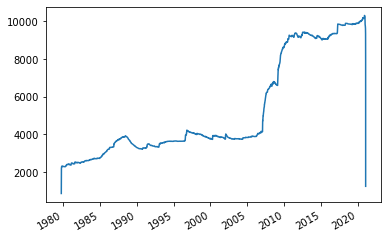

In [9]:
idx_vals.plot()